# Play with CMU Movie Dataset

In [1]:
import os
import re
import math
import gzip
import urllib
import string
import tarfile
import requests
import collections
import pandas as pd
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import seaborn as sns
import networkx as nx
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
%matplotlib inline

## Import the dataset

In [2]:
cmu_path = "data/MovieSummaries/"
corenlp_path = "data/CoreNLP/"
summary_raw_path = corenlp_path+"corenlp_plot_summaries/"
summary_path = corenlp_path+"corenlp_plot_summaries_xml/"
movies_path = cmu_path+"movie.metadata.tsv"
characters_path = cmu_path+"character.metadata.tsv"
plot_path = cmu_path+"plot_summaries.txt"

In [3]:
if not os.path.exists(movies_path):
    movie_url = 'http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(movie_url), mode="r:gz") 
    tar_file.extractall(path=movies_path)
    tar_file.close()

In [4]:
if not os.path.exists(corenlp_path):
    corenlp_url = 'http://www.cs.cmu.edu/~ark/personas/data/corenlp_plot_summaries.tar'
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(corenlp_url), mode="r|") 
    tar_file.extractall(path=corenlp_path)
    
    os.mkdir(summary_path)
    for filename in os.listdir(summary_raw_path):
        f = os.path.join(summary_raw_path, filename) 
        if os.path.isfile(f):
            with gzip.open(f, 'rb') as f_in:
                gz_file = os.path.join(summary_path, filename)
                with open(gz_file[:-3], 'wb') as f_out:
                    f_out.write(f_in.read())
    tar_file.close()

In [5]:
movies_column_names = [
    "wikipedia_id",
    "freebase_id",
    "name",
    "release_date",
    "box_office_revenue",
    "runtime",
    "languages",
    "countries",
    "genres"
]

characters_column_names = [
    "wikipedia_id",
    "freebase_id",
    "release_date",
    "character_name",
    "actor_dob",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age",
    "freebase_character_map",
    "freebase_character_id",
    "freebase_actor_id"
]

plot_column_names = ['wikipedia_id', 'summary']

movies = pd.read_csv(movies_path, sep='\t', header=None, names=movies_column_names)
characters = pd.read_csv(characters_path, sep='\t', header=None, names=characters_column_names)
plots = pd.read_csv(plot_path, sep='\t', header=None, names=plot_column_names)

In [6]:
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


The format of `release_date` is not unified.

In [7]:
characters.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [8]:
plots.head()

,wikipedia_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


We need to format `release_date`, `countries`, and `languages`.

## NaN check

In [9]:
print('Percentage of NaN values in the movie dataset (total {} rows):'.format(len(movies)))
print(movies.isna().sum() / len(movies) * 100)

Percentage of NaN values in the movie dataset (total 81741 rows):
wikipedia_id           0.000000
freebase_id            0.000000
name                   0.000000
release_date           8.443743
box_office_revenue    89.722416
runtime               25.018045
languages              0.000000
countries              0.000000
genres                 0.000000
dtype: float64


It's hard to use box_office_revenue unless we find another dataset... Also I think `runtime` is not important for gender analysis. Maybe we can find some ways to fill in the missing releasing dates.

In [10]:
print('Percentage of NaN values in the character dataset (total {} rows):'.format(len(characters)))
print(characters.isna().sum() / len(characters) * 100)

Percentage of NaN values in the character dataset (total 450669 rows):
wikipedia_id               0.000000
freebase_id                0.000000
release_date               2.217814
character_name            57.220488
actor_dob                 23.552763
actor_gender              10.120288
actor_height              65.645740
actor_ethnicity           76.466542
actor_name                 0.272484
actor_age                 35.084064
freebase_character_map     0.000000
freebase_character_id     57.218269
freebase_actor_id          0.180842
dtype: float64


We don't care about any id related to freebase, height, ethnicity, and dob. `character_name` is quite necessary for gender analysis on plots. 10% of the genders of actors are missing. `actor_age` is also important but not for my focus now.

In [11]:
print('Percentage of NaN values in the plot dataset (total {} rows):'.format(len(plots)))
print(plots.isna().sum() / len(plots) * 100)

Percentage of NaN values in the plot dataset (total 42303 rows):
wikipedia_id    0.0
summary         0.0
dtype: float64


We have 81741 movies (ignore possible duplicated movies), but only 42303 of them have plot summaries.

In [12]:
plots.wikipedia_id.duplicated().sum()

0

From above we can see there's no duplicated movies in the plot dadtaset. Therefore, we only focus on these movies.

## Language, Countries, and Genres

They are encoded in weird formats...

In [6]:
get_dict_keys = lambda x: np.nan    if x=={} \
                    else  [re.sub(r"\x20[Ll]anguage", "", w) for w in re.findall(r'"(.*?)"', x)[1::2]]
movies.countries = movies.countries.apply(get_dict_keys)
movies.languages = movies.languages.apply(get_dict_keys)
movies.genres = movies.genres.apply(get_dict_keys)

In [7]:
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [15]:
movies.languages.dropna()[movies.languages.dropna().apply(len)>1]

5        [Silent film, English]
48       [Silent film, English]
49         [Afrikaans, English]
51       [Silent film, English]
52       [Silent film, English]
                  ...          
81688          [French, Arabic]
81692    [Silent film, English]
81697        [English, Spanish]
81725        [Italian, English]
81735        [Russian, English]
Name: languages, Length: 9807, dtype: object

In [16]:
movies.countries.dropna()[movies.countries.dropna().apply(len)>1]

26                                         [France, Italy]
33              [United States of America, United Kingdom]
38                                [Australia, New Zealand]
47                 [United States of America, Netherlands]
53                      [Mexico, United States of America]
                               ...                        
81694    [Kingdom of Great Britain, Japan, England, Uni...
81699                [United States of America, Hong Kong]
81717    [Switzerland, Italy, West Germany, German Demo...
81725                   [France, United States of America]
81737                            [Ireland, United Kingdom]
Name: countries, Length: 9218, dtype: object

Country names are changing and there are "Slient film" in the languages...

## What I want to study

Gender stereotype analysis using **Entity Graph**

- We could examine the role, action, and relationship of gender characters from movie plot summaries using the **entity-linking graph**, calculating the most important words for each entity.
- We could also study how gender stereotypes vary from **genre to genre** to know their correlation.

First join plot summaries to movies dataset.

In [8]:
movies_plots = pd.merge(movies, plots, on="wikipedia_id", how="inner")[[
    "wikipedia_id",
    "release_date",
    "languages",
    "countries",
    "genres",
    "summary"
]]
movies_plots

,wikipedia_id,release_date,languages,countries,genres,summary
0,975900,2001-08-24,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,1987,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,1983,[German],[Germany],[Drama],"Eva, an upper class housewife, becomes frustra..."
3,18998739,2002,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
4,6631279,1997-04-04,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."
...,...,...,...,...,...,...
42199,23851782,1941-05-03,[English],[United Kingdom],"[Crime Fiction, Thriller, Comedy, Supernatural]",{{plot}} The film opens with a Great Western e...
42200,35228177,2011-03-19,[English],[United States of America],[Drama],Two former National Oceanic Atmospheric Admini...
42201,34980460,2011-01-21,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]",{{No plot}} This film follows 12 years in the ...
42202,913762,1992-05-21,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ...","The story takes place in the year 2092,The Sup..."


Then filter movies with plots containing character names in characters dataframe and add these character names in the movies dataframe.

In [9]:
characters_filtered = characters.dropna(subset=['character_name', 'actor_gender'])
characters_filtered

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450661,913762,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz
450662,913762,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd
450663,913762,/m/03pcrp,1992-05-21,Exegran,NaN,M,NaN,NaN,Hal Cleaveland,NaN,/m/0kr407c,/m/0kr406_,/m/0kr407h
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv


In [10]:
temp_df = movies_plots[movies_plots.wikipedia_id.isin(characters_filtered.wikipedia_id)]

In [11]:
index = []
name_gender = []
count_gender = {'M': 0, 'F': 0}
for i in range(len(temp_df)):
    temp_name_gender = {}
    flag = 0
    filtered = characters_filtered[characters_filtered.wikipedia_id==temp_df.iloc[i].wikipedia_id]
    for word, gender in zip(filtered.character_name.apply(str.lower), filtered.actor_gender):
        if word in temp_df.iloc[i].summary.lower(): # only consider full match. i.e. full character name matches with the plot summary.
            if flag == 0:                           # if there's one full match in the plot summary, we keep this movie.
                index.append(i)
                flag = 1
            temp_name_gender[word] = gender
            count_gender[gender] += 1
    if flag == 1:
        name_gender.append(temp_name_gender)

assert len(name_gender)==len(index)

In [12]:
print("Male: {}".format(count_gender['M']))
print("Female: {}".format(count_gender['F']))

Male: 30343
Female: 15842


In [62]:
movies_plots_filtered = temp_df.iloc[index].copy()
movies_plots_filtered.loc[:, 'character_names'] = name_gender
movies_plots_filtered = movies_plots_filtered.reset_index(drop=True)
movies_plots_filtered

,wikipedia_id,release_date,languages,countries,genres,summary,character_names
0,975900,2001-08-24,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",{'desolation williams': 'M'}
1,18998739,2002,[English],[South Africa],"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",{'morgana': 'F'}
2,6631279,1997-04-04,[English],[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...","{'rebecca': 'F', 'nina': 'F'}"
3,171005,1989-11-08,[English],[United Kingdom],"[Costume drama, War film, Epic, Period piece, ...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...,{'henry v': 'M'}
4,77856,1964-08-27,[English],[United States of America],"[Children's/Family, Musical, Fantasy, Comedy, ...",The film opens with Mary Poppins perched in a...,"{'george banks': 'M', 'bert': 'M', 'mary poppi..."
...,...,...,...,...,...,...,...
16700,24997872,2010-05-07,[Malayalam],[India],[Drama],The film revolves around Madhavan Nair who unk...,"{'raja': 'M', 'surya': 'M', 'aswathy': 'F'}"
16701,7761830,1990,[English],[United States of America],"[Alien Film, Science Fiction, Family Film, Com...","The space armada from Mars, known as the Imper...",{'kathy': 'F'}
16702,1918494,2000-08-26,"[Italian, English]","[France, United States of America]","[Parody, Americana, Comedy]",Havoc is wrought on the inhabitants of a small...,"{'ann': 'F', 'carla': 'F', 'walt price': 'M', ..."
16703,15394941,1994-12-02,[Hindi],[India],"[Drama, Action, Crime, Comedy]",Kishan killed a man in his childhood when the...,{'sawant': 'M'}


Now use the stupid f**king `for` loop to extract nouns, verbs, and adjectives around male and female character names.

And put these words in `male_dict` and `female_dict` to calculate the frequency of words.

In [80]:
gender_dict = {'M': {}, 'F': {}}
pos_filter = [
    'JJ', 'JJR', 'JJS',
    'NN', 'NNS', 'NNP', 'NNPS',
    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
]
window_size = 3     # search three words of {n., adj., v.} before first name and after last name if possible.

In [87]:
for i in range(len(movies_plots_filtered)):
# for i in range(100):  # debugging
    genders = movies_plots_filtered.iloc[i].character_names
    wiki_id = movies_plots_filtered.iloc[i].wikipedia_id
    for character_name in genders:
        gender = genders[character_name]
        assert gender == 'F' or gender == 'M'
        name_list = character_name.split()      # 'yiyang feng' -> ['yiyang', 'feng']
        first_name = name_list[0]
        last_name = name_list[-1]

        tree = ET.parse(summary_path+str(wiki_id)+".xml")   # use corenlp data
        root = tree.getroot()
        pos_list = root.findall(".//*POS")
        word_list = root.findall(".//*lemma")

        idx, length = 0, len(word_list)
        count_head, count_tail = 0, 0
        while idx<length:
            if word_list[idx].text.lower() == first_name and word_list[min(idx+len(name_list)-1, length-1)].text.lower() == last_name:
                head_idx = idx
                tail_idx = idx+len(name_list)-1
                
                # search w1, w2, ... before first name ([w1, w2, ..., 'yiyang', 'feng', ...])
                for pre_idx in range(head_idx-1, -1, -1):
                    if pos_list[pre_idx].text in pos_filter:
                        if word_list[pre_idx].text.lower() not in gender_dict[gender].keys():
                            gender_dict[gender][word_list[pre_idx].text.lower()] = 1
                            count_head += 1
                        else:
                            gender_dict[gender][word_list[pre_idx].text.lower()] += 1
                            count_head += 1
                    
                    if count_head == window_size:
                        break

                    if word_list[pre_idx].text in string.punctuation:   # don't search across sentences!
                        break

                # search v1, v2, ... after last name ([..., 'yiyang', 'feng', v1, v2, ...])
                for nxt_idx in range(tail_idx+1, length):
                    if pos_list[nxt_idx].text in pos_filter:
                        if word_list[nxt_idx].text.lower() not in gender_dict[gender].keys():
                            gender_dict[gender][word_list[nxt_idx].text.lower()] = 1
                            count_tail += 1
                        else:
                            gender_dict[gender][word_list[nxt_idx].text.lower()] += 1
                            count_tail += 1
                    
                    if count_tail == window_size:
                        break

                    if word_list[nxt_idx].text in string.punctuation:   # don't search across sentences!
                        break

                idx = tail_idx+1

            else:
                idx += 1

In [95]:
collections.Counter(gender_dict['M']).most_common(23)[3:]   # ignore 'be', 'have', and 'tell'

[('kill', 3836),
 ('find', 3612),
 ('go', 3235),
 ('take', 3159),
 ('get', 3131),
 ('leave', 2561),
 ('try', 2252),
 ('friend', 2207),
 ('meet', 2170),
 ('do', 2146),
 ('see', 2100),
 ('name', 2055),
 ('make', 1849),
 ('come', 1827),
 ('give', 1778),
 ('father', 1700),
 ('help', 1680),
 ('love', 1657),
 ('return', 1627),
 ('ask', 1585)]

In [94]:
collections.Counter(gender_dict['F']).most_common(23)[3:]

[('find', 2139),
 ('go', 2007),
 ('take', 1727),
 ('get', 1676),
 ('love', 1616),
 ('leave', 1548),
 ('meet', 1464),
 ('see', 1390),
 ('name', 1322),
 ('do', 1270),
 ('kill', 1196),
 ('try', 1174),
 ('friend', 1148),
 ('marry', 1124),
 ('ask', 1066),
 ('come', 1039),
 ('make', 1019),
 ('house', 967),
 ('mother', 949),
 ('return', 945)]

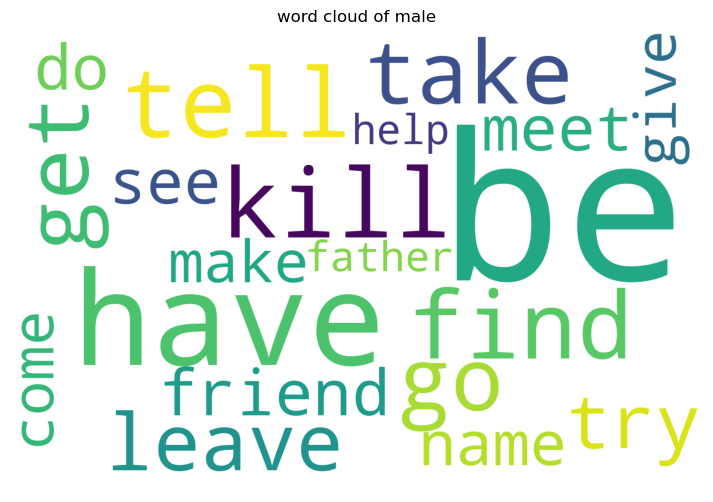

In [104]:
wordcloud = WordCloud(background_color='white',
                      width=1500,
                      height=1000,
                    #   stopwords={"be", "have", "tell"},
                      max_words=20
                      ).generate_from_frequencies(gender_dict['M'])
# use .generate(space_separated_string) - to generate cloud from text

plt.figure(figsize=(9,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('word cloud of male')
plt.show()

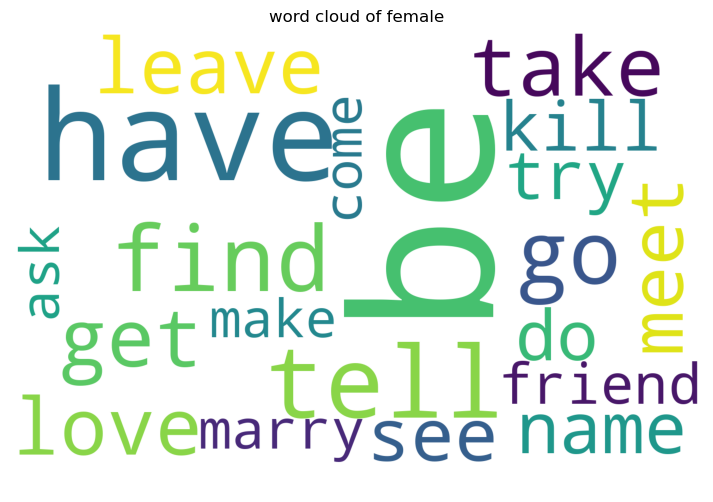

In [103]:
wordcloud = WordCloud(background_color='white',
                      width=1500,
                      height=1000,
                    #   stopwords={"be", "have", "tell"},
                      max_words=20
                      ).generate_from_frequencies(gender_dict['F'])
# use .generate(space_separated_string) - to generate cloud from text

plt.figure(figsize=(9,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('word cloud of female')
plt.show()